In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
# import tensorflow_datasets as tfds
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, Embedding, Bidirectional
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import metrics
from sklearn.svm import SVC

In [2]:
## Importing the data and creating a list of all data points

lists = []
with open('amazon_cells_labelled.txt','r') as data_file:
    for line in data_file:
        data = line.split('\t')
        #print(data)
        lists.append(data)

In [3]:
## Creating separate lists of the reviews and labels and checking the lengths

reviews = []
labels = []

for i in range(0, len(lists)):
    reviews.append(lists[i][0])
    labels.append(int(lists[i][1]))

print(reviews[:5])
print(labels[:5])
print(lists[:5])
print(len(reviews) == len(labels))
print(len(reviews) == len(lists))
print(len(labels) == len(lists))

['So there is no way for me to plug it in here in the US unless I go by a converter.', 'Good case, Excellent value.', 'Great for the jawbone.', 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!', 'The mic is great.']
[0, 1, 1, 0, 1]
[['So there is no way for me to plug it in here in the US unless I go by a converter.', '0\n'], ['Good case, Excellent value.', '1\n'], ['Great for the jawbone.', '1\n'], ['Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!', '0\n'], ['The mic is great.', '1\n']]
True
True
True


In [4]:
data = pd.DataFrame({'Reviews': reviews, 'Labels': labels})

In [5]:
print(data.head())

                                             Reviews  Labels
0  So there is no way for me to plug it in here i...       0
1                        Good case, Excellent value.       1
2                             Great for the jawbone.       1
3  Tied to charger for conversations lasting more...       0
4                                  The mic is great.       1


In [6]:
## https://www.geeksforgeeks.org/python-program-check-string-contains-special-character/

unusual = []

def check_special_char_ascii(string):
    for char in string:
        if ord(char) < 32 or (32 < ord(char) < 65) or (90 < ord(char) < 97) or ord(char) > 122:
            unusual.append(ord(char))

In [7]:
for i in range(0, len(data['Reviews'])):
    check_special_char_ascii(data['Reviews'][i])
unusual = pd.DataFrame({'Unusual': unusual})
unusual.value_counts()

Unusual
46         1079
44          293
39          180
33          167
45           74
50           45
48           43
53           37
49           33
41           29
40           26
51           23
34           19
56           11
52           10
55           10
59            9
36            9
47            8
38            7
63            7
54            5
58            4
42            4
37            2
57            2
35            2
43            1
91            1
93            1
dtype: int64

In [8]:
def replace_unusual_with_nothing(string):
    for char in string:
        if ord(char) < 32 or (32 < ord(char) < 65) or (90 < ord(char) < 97) or ord(char) > 122:
            #print(char)
            string = string.replace(char, ' ')
            #print(string)
    data['Reviews'][i] = string
    #print(edited_reviews)

In [9]:
#testing = ['Hello$ World!@', 'wervbow$ eregv#']

In [10]:
#for i in range(0, len(testing)):
    #replace_unusual_with_nothing(testing[i])

In [11]:
for i in range(0, len(data['Reviews'])):
    replace_unusual_with_nothing(data['Reviews'][i])

In [12]:
## https://www.geeksforgeeks.org/python-program-check-string-contains-special-character/

unusual_removed = []

def check_special_char_ascii_removed(string):
    for char in string:
        if ord(char) < 32 or (32 < ord(char) < 48) or (57 < ord(char) < 65) or (90 < ord(char) < 97) or ord(char) > 122:
            unusual_removed.append(ord(char))

In [13]:
for i in range(0, len(data['Reviews'])):
    check_special_char_ascii_removed(data['Reviews'][i])
unusual_removed = pd.DataFrame({'Unusual': unusual_removed})
unusual_removed.value_counts()

Series([], dtype: int64)

In [14]:
print(data.head())

                                             Reviews  Labels
0  So there is no way for me to plug it in here i...       0
1                        Good case  Excellent value        1
2                             Great for the jawbone        1
3  Tied to charger for conversations lasting more...       0
4                                  The mic is great        1


In [15]:
## https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

from nltk.corpus import stopwords
import re
stop_words = set(stopwords.words('english'))

for i in range(0, len(data['Reviews'])):
    ## Changing everything to lowercase
    data['Reviews'][i] = data['Reviews'][i].lower()
    
    ## Removing stopwords
    data['Reviews'][i] = ' '.join([w for w in data['Reviews'][i].split() if w not in stop_words])
    
    #Removing extra spaces
    data['Reviews'][i] = re.sub(r'\s+', ' ', data['Reviews'][i]).strip()
print(data.head())

                                             Reviews  Labels
0                    way plug us unless go converter       0
1                          good case excellent value       1
2                                      great jawbone       1
3  tied charger conversations lasting minutes maj...       0
4                                          mic great       1


In [16]:
## https://www.datacamp.com/tutorial/python-bag-of-words-model
# Build the vocabulary
vocab_len = []
for i in range(0, len(data)):
    b = data['Reviews'][i].split()
    vocab_len.append(b)
#print("Total Vocab:", vocab_len)

In [17]:
total_words = 0
for i in range(0, len(vocab_len)):
    total_words = total_words + len(vocab_len[i])
print(total_words)

5180


In [18]:
# Initialize an empty set for the vocabulary
vocabulary = set()

# Build the vocabulary
for sentence in vocab_len:
    vocabulary.update(sentence)

# Convert to a sorted list
vocabulary = sorted(list(vocabulary))
#print("Vocabulary:", vocabulary)
print("Total Amount of Words in Vocabulary: ", total_words)
print("Unique Vocabulary Size: ", len(vocabulary))

Total Amount of Words in Vocabulary:  5180
Unique Vocabulary Size:  1689


In [19]:
max_length = data['Reviews'].str.len().max()
print(max_length)

114


In [20]:
##https://westerngovernorsuniversity-my.sharepoint.com/personal/william_sewell_wgu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fwilliam%5Fsewell%5Fwgu%5Fedu%2FDocuments%2FDocuments%2FD213%2FWebinars%2FD213%5FTask2%5FSentiment%5FAnalysis%5FAns%5FYelpOnly%2Ehtml&parent=%2Fpersonal%2Fwilliam%5Fsewell%5Fwgu%5Fedu%2FDocuments%2FDocuments%2FD213%2FWebinars&ga=1

#print(text)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Reviews'])
encoded_docs = tokenizer.texts_to_sequences(data['Reviews'])
padded_sequence = pad_sequences(encoded_docs, padding = 'post', maxlen = max_length)


In [21]:
print(padded_sequence)

[[ 128   80  433 ...    0    0    0]
 [   3   17   18 ...    0    0    0]
 [   2  316    0 ...    0    0    0]
 ...
 [  35  350  156 ...    0    0    0]
 [  67 1686 1687 ...    0    0    0]
 [ 678   65  127 ...    0    0    0]]


In [22]:
data['padded_sequence'] = padded_sequence.tolist()

In [23]:
print(padded_sequence[0])

[128  80 433 315 149 687   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]


In [24]:
print(data['padded_sequence'][0])

[128, 80, 433, 315, 149, 687, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [25]:
## Creating the training, validation, and test sets
from sklearn.model_selection import train_test_split
X_train, X, y_train, y = train_test_split(padded_sequence, data['Labels'].values, test_size=0.3, random_state=10)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

In [26]:
print("Percentage of training set: ", 100 * (len(X_train) / len(data)), '%')
print("Percentage of validation set: ", 100 * (len(X_val) / len(data)), '%')
print("Percentage of test set: ", 100 * (len(X_test) / len(data)), '%')

Percentage of training set:  70.0 %
Percentage of validation set:  15.0 %
Percentage of test set:  15.0 %


In [27]:
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [28]:
data.to_csv('edited_data.csv', index = False)

In [29]:
## https://www.geeksforgeeks.org/deep-learning-introduction-to-long-short-term-memory/
## https://westerngovernorsuniversity-my.sharepoint.com/personal/william_sewell_wgu_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fwilliam%5Fsewell%5Fwgu%5Fedu%2FDocuments%2FDocuments%2FD213%2FWebinars%2FD213%5FTask2%5FSentiment%5FAnalysis%5FAns%5FYelpOnly%2Ehtml&parent=%2Fpersonal%2Fwilliam%5Fsewell%5Fwgu%5Fedu%2FDocuments%2FDocuments%2FD213%2FWebinars&ga=1
embed_size = 128
model = Sequential()
model.add(Embedding(input_dim = len(vocabulary) + 1, output_dim = embed_size))
model.add(Bidirectional(LSTM(units=128, return_sequences=False)))
model.add(Dropout(0.5))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
model.build(input_shape = (None, max_length))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 114, 128)            │         216,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 496,001 (1.89 MB)

 Trainable params: 496,001 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stopping_monitor = EarlyStopping(patience=3)
history = model.fit(X_train,y_train, epochs=20, batch_size=64, validation_data=(X_val,y_val), callbacks = [early_stopping_monitor])

Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 481ms/step - accuracy: 0.5207 - loss: 0.6929 - val_accuracy: 0.4600 - val_loss: 0.6935
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 367ms/step - accuracy: 0.6653 - loss: 0.6827 - val_accuracy: 0.6133 - val_loss: 0.6775
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 377ms/step - accuracy: 0.7701 - loss: 0.6356 - val_accuracy: 0.6933 - val_loss: 0.5941
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 354ms/step - accuracy: 0.8596 - loss: 0.4612 - val_accuracy: 0.7667 - val_loss: 0.4987
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 365ms/step - accuracy: 0.9457 - loss: 0.1894 - val_accuracy: 0.7533 - val_loss: 0.5363
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 367ms/step - accuracy: 0.9710 - loss: 0.0992 - val_accuracy: 0.7933 - val_loss: 0.6823
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 374ms/step - accuracy: 0.9875 - loss: 0.0530 - val_accuracy: 0.7467 - val_loss: 0.6524


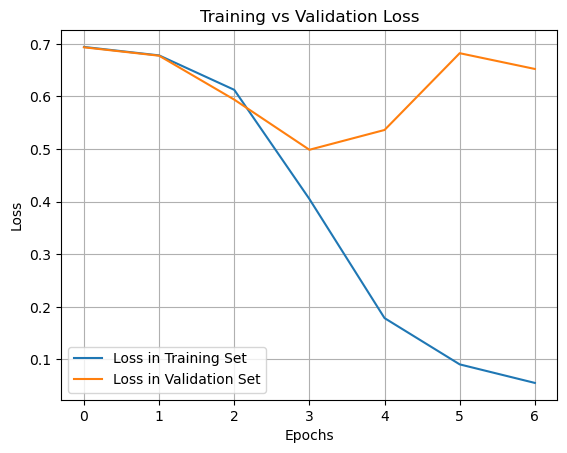

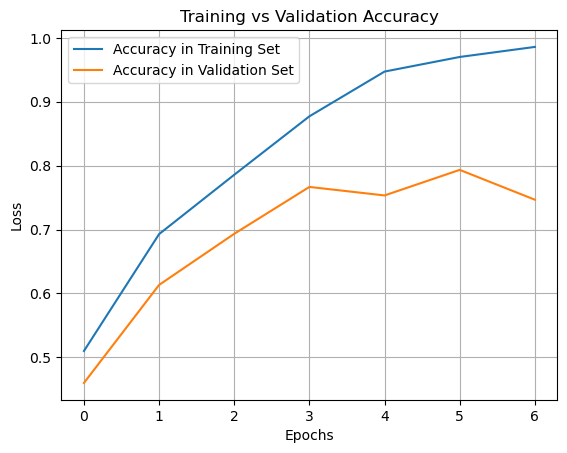

In [32]:
## Plotting the loss in the training set compared to the loss in the validation set

plt.plot(history.history['loss'], label='Loss in Training Set')
plt.plot(history.history['val_loss'], label='Loss in Validation Set')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

plt.plot(history.history['accuracy'], label='Accuracy in Training Set')
plt.plot(history.history['val_accuracy'], label='Accuracy in Validation Set')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7949 - loss: 0.5229
Test Accuracy: 0.800000011920929


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step


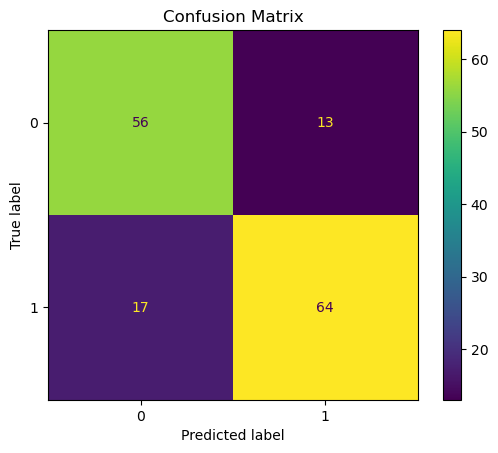

              precision    recall  f1-score   support

           0       0.77      0.81      0.79        69
           1       0.83      0.79      0.81        81

    accuracy                           0.80       150
   macro avg       0.80      0.80      0.80       150
weighted avg       0.80      0.80      0.80       150



In [34]:
## Accuracy tests
y_pred = (model.predict(X_test) >= 0.5).astype(int)

## Building the confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cnf_matrix)
disp.plot()
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred))

In [35]:
model.save("Trained_Model.keras")